## Módulos

In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import warnings


In [12]:
warnings.filterwarnings('ignore')

In [7]:
modelo_b_df_twitter=pd.read_csv("./BTCsentimentprocesado.csv")
modelo_b_df_twitter["Date"] = pd.to_datetime(modelo_b_df_twitter["Date"])


## Datos

Los datos empleados son:
- precio diario de cierre BTC/USD (target)
- twitter sentiment
- rango de tiempo 01/01/2019-31/12/2019

In [8]:
modelo_b_df_twitter

,Date,Close,twitter_hacks,twitter_pessimistic_doubtful,twitter_banks,twitter_selling,twitter_market_manipulation,twitter_de_centralisation,twitter_angry,twitter_etf,...,twitter_buying,twitter_warning,twitter_annoyed_frustrated,twitter_price,twitter_use_case_applications,twitter_rumor,twitter_scam_fraud,twitter_airdrop,twitter_optimistic,twitter_negative
0,2019-01-01,3843.520020,0.208333,0.541667,1.583333,1.125000,0.416667,1.250000,0.541667,0.333333,...,1.375000,0.083333,0.083333,26.916667,4.458333,0.166667,1.291667,0.000000,3.000000,13.208333
1,2019-01-02,3943.409424,0.458333,1.000000,1.500000,1.500000,0.916667,1.833333,0.375000,0.416667,...,2.500000,0.416667,0.041667,35.125000,4.458333,0.083333,2.291667,0.083333,4.333333,16.541667
2,2019-01-03,3836.741211,0.250000,1.250000,2.958333,1.583333,0.750000,2.666667,0.500000,0.333333,...,3.166667,0.416667,0.041667,35.708333,6.666667,0.250000,2.958333,0.166667,5.666667,20.125000
3,2019-01-04,3857.717529,0.333333,0.666667,1.875000,1.625000,0.500000,1.666667,0.666667,0.208333,...,2.500000,0.458333,0.083333,30.625000,6.583333,0.041667,2.375000,0.166667,4.750000,18.291667
4,2019-01-05,3845.194580,0.125000,0.666667,1.333333,1.291667,0.416667,1.541667,0.416667,0.166667,...,2.541667,0.583333,0.041667,28.833333,4.875000,0.250000,2.541667,0.083333,4.291667,15.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2024-12-27,94164.859375,0.041667,0.208333,0.125000,0.458333,0.083333,0.333333,0.083333,1.250000,...,1.166667,0.041667,0.041667,6.916667,0.416667,0.041667,0.250000,0.083333,1.208333,3.875000
2188,2024-12-28,95163.929688,0.041667,0.166667,0.083333,0.250000,0.041667,0.250000,0.000000,0.250000,...,0.750000,0.041667,0.000000,5.666667,0.583333,0.000000,0.125000,0.083333,0.875000,3.500000
2189,2024-12-29,93530.226562,0.000000,0.125000,0.041667,0.541667,0.041667,0.083333,0.166667,0.125000,...,1.500000,0.250000,0.000000,6.291667,0.666667,0.125000,0.083333,0.000000,0.958333,3.833333
2190,2024-12-30,92643.210938,0.083333,0.291667,0.625000,0.666667,0.125000,0.541667,0.083333,0.791667,...,1.708333,0.208333,0.000000,9.333333,1.083333,0.083333,0.041667,0.000000,1.500000,5.166667


## Modelo LSTM multistep

*¿Qué hace este modelo?*
> para un momento i, predice una ventana futura (horizon) en base a una ventana pasada (lookback)

> itera de esta forma para toda la serie temporal

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 256)           359424    
                                                                 
 dropout_22 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 7)                 903       
                                                                 
Total params: 557447 (2.13 MB)
Trainable params: 557447 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
5/5 [=

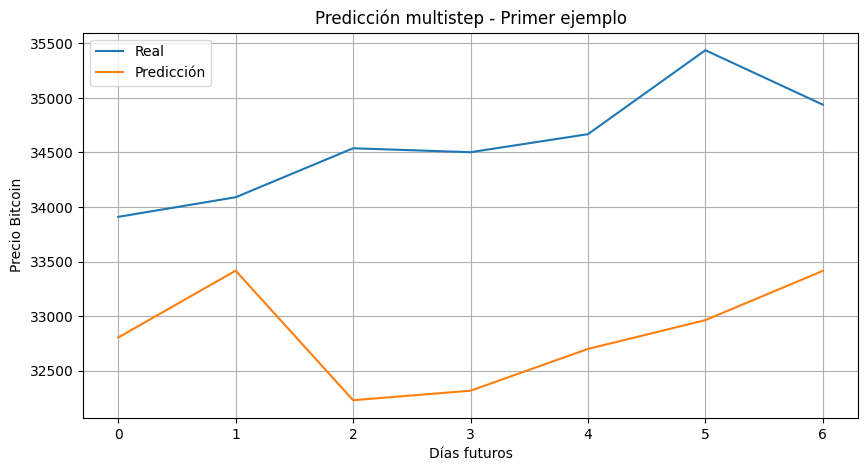

In [44]:


# -----------------------------
# PARÁMETROS
# -----------------------------
lookback = 60      # Número de días pasados para mirar
horizon = 7        # Número de días futuros a predecir
test_size = 0.2    # Fracción para test
batch_size = 350
epochs = 25

# -----------------------------
# CARGA Y PREPROCESAMIENTO
# -----------------------------
df = modelo_b_df_twitter.copy()
df.drop(columns=["Date"], inplace=True)  # Quitamos fecha

# Target y features
target_col = "Close"
target = df[[target_col]]
features = df.drop(columns=[target_col])

# Escalado
target_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()

target_scaled = target_scaler.fit_transform(target)
features_scaled = feature_scaler.fit_transform(features)

# Concatenar para crear un dataset multivariado
scaled_df = np.concatenate([target_scaled, features_scaled], axis=1)

# -----------------------------
# SECUENCIAS (X: multivariado, y: solo Close)
# -----------------------------
def create_sequences(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])  # full features
        y.append(data[i+lookback:i+lookback+horizon, 0])  # solo Close
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, lookback, horizon)

# Train/test split sin shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# -----------------------------
# MODELO LSTM MULTISTEP
# -----------------------------
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(lookback, X.shape[2]),use_bias=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(horizon)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# -----------------------------
# ENTRENAMIENTO
# -----------------------------
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# -----------------------------
# PREDICCIONES E INVERSIÓN DE ESCALADO
# -----------------------------
y_pred = model.predict(X_test)

# Reshape para invertir escala
y_pred_flat = y_pred.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)

# Inversión de escalado solo para la columna 'Close'
y_pred_inv = target_scaler.inverse_transform(y_pred_flat).reshape(y_pred.shape)
y_test_inv = target_scaler.inverse_transform(y_test_flat).reshape(y_test.shape)

# -----------------------------
# VISUALIZACIÓN EJEMPLO
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[0], label="Real")
plt.plot(y_pred_inv[0], label="Predicción")
plt.title("Predicción multistep - Primer ejemplo")
plt.xlabel("Días futuros")
plt.ylabel("Precio Bitcoin")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
mae = mean_absolute_error(y_test_inv[0],y_pred_inv[0] )
print(f"MAE de la predicción de la primera ventana : {mae:.2f}")

MAE de la predicción de la primera ventana : 1748.80


In [46]:

for i in range(426):
    mae_list=[]
    mae = mean_absolute_error(y_test_inv[i],y_pred_inv[i] )
    mae_list.append(mae)
    print(f"MAE de la predicción de la {i} ventana : {mae:.2f}")

print(f" media de los MAEs de todas las ventanas : {sum(mae_list)/len(mae_list)}")

MAE de la predicción de la 0 ventana : 1748.80
MAE de la predicción de la 1 ventana : 1355.24
MAE de la predicción de la 2 ventana : 1093.42
MAE de la predicción de la 3 ventana : 881.40
MAE de la predicción de la 4 ventana : 573.02
MAE de la predicción de la 5 ventana : 642.47
MAE de la predicción de la 6 ventana : 611.46
MAE de la predicción de la 7 ventana : 777.13
MAE de la predicción de la 8 ventana : 961.71
MAE de la predicción de la 9 ventana : 1153.83
MAE de la predicción de la 10 ventana : 1130.31
MAE de la predicción de la 11 ventana : 1153.08
MAE de la predicción de la 12 ventana : 993.86
MAE de la predicción de la 13 ventana : 1005.88
MAE de la predicción de la 14 ventana : 1179.28
MAE de la predicción de la 15 ventana : 786.48
MAE de la predicción de la 16 ventana : 843.97
MAE de la predicción de la 17 ventana : 1000.46
MAE de la predicción de la 18 ventana : 860.58
MAE de la predicción de la 19 ventana : 1371.93
MAE de la predicción de la 20 ventana : 1038.57
MAE de la pr

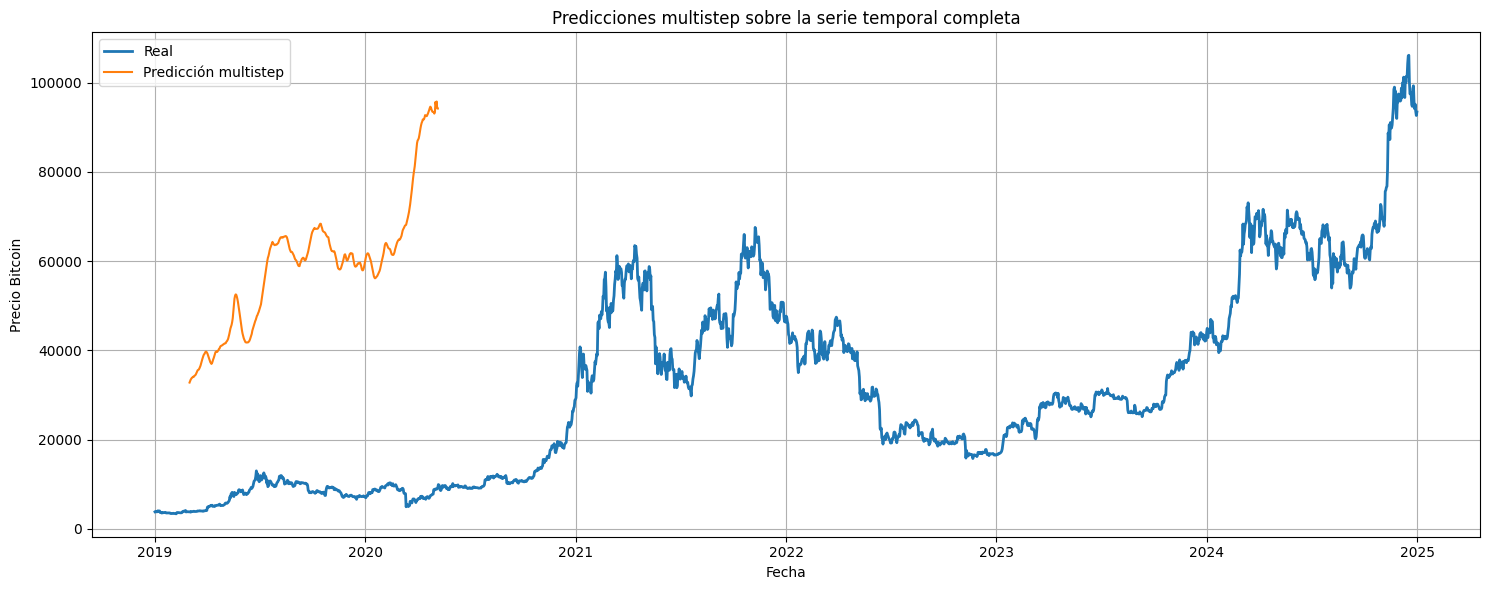

In [47]:
# -----------------------------
# GRAFICAR TODAS LAS PREDICCIONES EN LA SERIE
# -----------------------------

#¿Qué es esto ?
#promedio de las ventanas de predicción para graficar

import matplotlib.dates as mdates

# Crear array vacío del tamaño de la serie original con NaNs
n_total = len(df)
pred_plot = [np.nan] * (lookback + horizon - 1)  # padding inicial

# Vamos agregando las predicciones una por una (sin promediar)
for i in range(len(y_pred_inv)):
    for j in range(horizon):
        idx = i + lookback + j
        if idx < n_total:
            if len(pred_plot) <= idx:
                pred_plot.append(y_pred_inv[i, j])
            else:
                pred_plot[idx] = y_pred_inv[i, j]

# Padding final si es necesario
while len(pred_plot) < n_total:
    pred_plot.append(np.nan)

# Valor real (solo el target 'Close')
close_real = df["Close"].values

# Fechas
dates = modelo_b_df_twitter["Date"]

# -----------------------------
# PLOTEO
# -----------------------------
plt.figure(figsize=(15, 6))
plt.plot(dates, close_real, label="Real", linewidth=2)
plt.plot(dates, pred_plot, label="Predicción multistep", linewidth=1.5)
plt.title("Predicciones multistep sobre la serie temporal completa")
plt.xlabel("Fecha")
plt.ylabel("Precio Bitcoin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


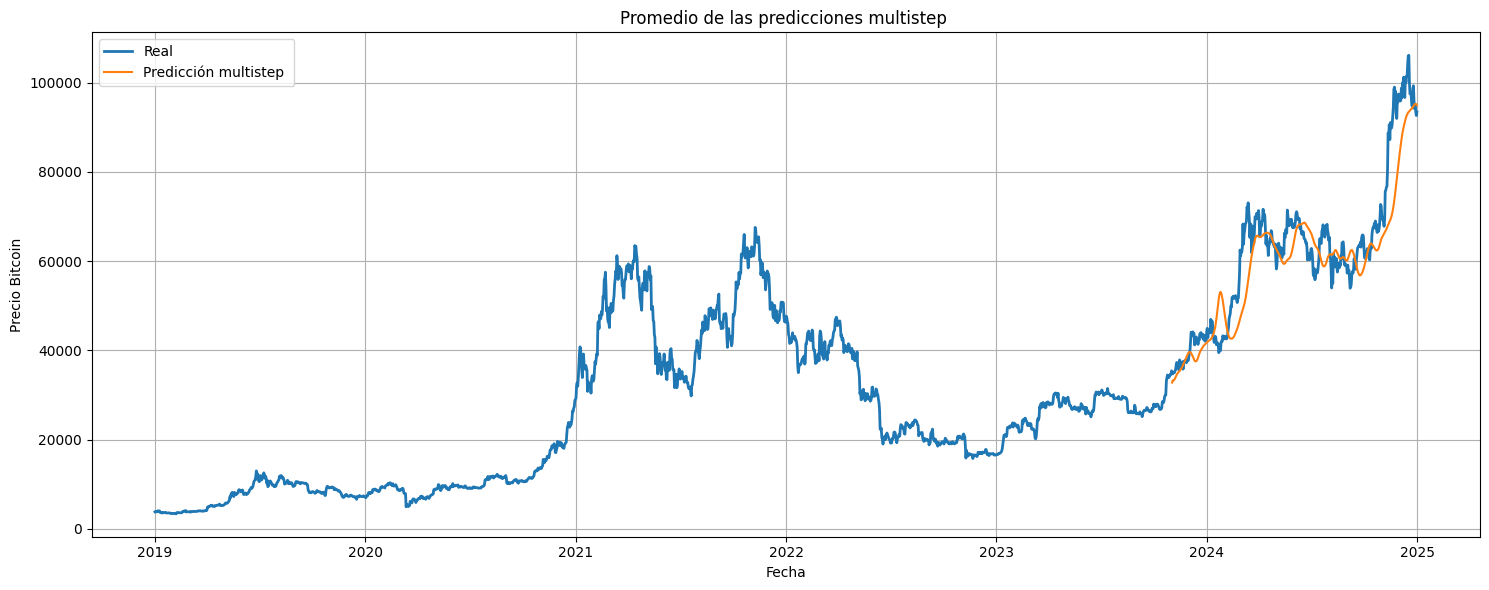

In [48]:
#alinear predicciones con las fechas reales



# Longitud total de la serie original
dates = modelo_b_df_twitter["Date"]
n_total = len(dates)

# Inicializar arrays para acumulación
pred_sum = np.zeros(n_total)
pred_count = np.zeros(n_total)

# Alinear desde el final
for i in range(len(y_pred_inv)):
    for j in range(horizon):
        # Contar desde el final
        idx = n_total - (len(y_pred_inv) - i) * 1 + j  # avance normal por j
        if 0 <= idx < n_total:
            pred_sum[idx] += y_pred_inv[i, j]
            pred_count[idx] += 1

# Evitar división por cero
with np.errstate(divide='ignore', invalid='ignore'):
    pred_avg = np.where(pred_count != 0, pred_sum / pred_count, np.nan)

# -----------------------------
# GRAFICO
# -----------------------------
plt.figure(figsize=(15, 6))
plt.plot(dates, close_real, label="Real", linewidth=2)
plt.plot(dates, pred_avg, label="Predicción multistep ", linewidth=1.5)
plt.title("Promedio de las predicciones multistep ")
plt.xlabel("Fecha")
plt.ylabel("Precio Bitcoin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Predicción a 7 días out-of-sample

1/1 [==============================] - 0s 98ms/step


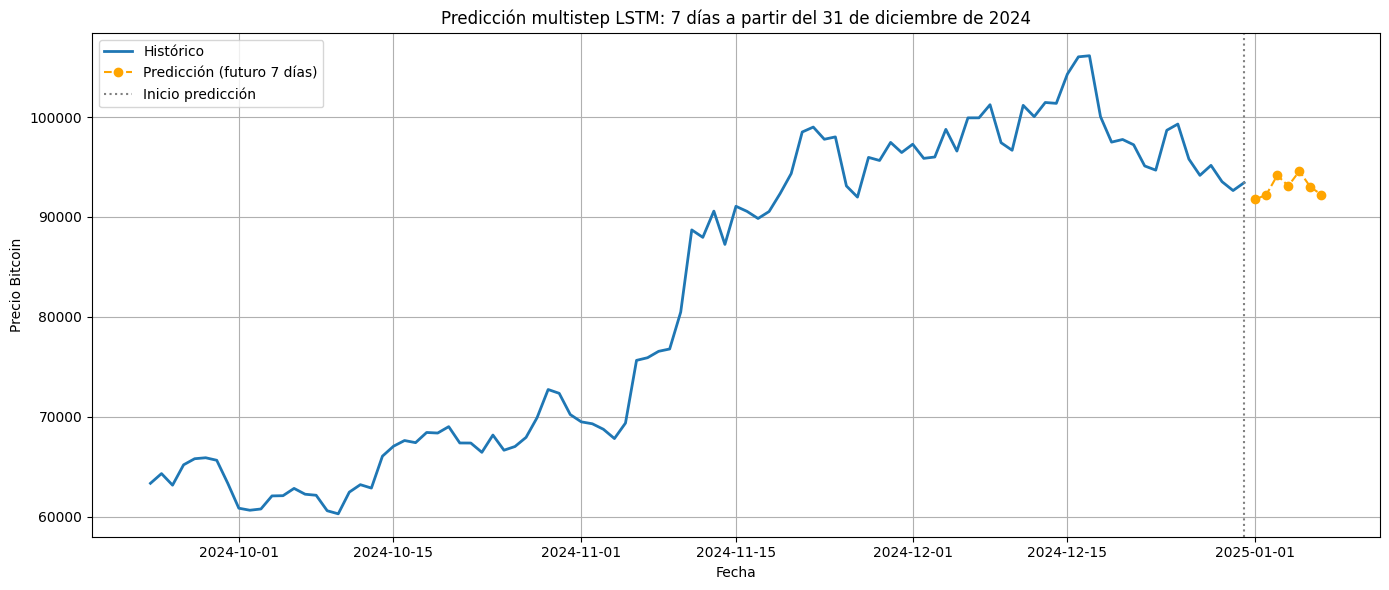

In [49]:
from datetime import timedelta

# -----------------------------
# PREDICCIÓN MULTISTEP OUT-OF-SAMPLE
# -----------------------------

# Últimos 60 días de datos
last_sequence = scaled_df[-lookback:]  # shape (60, n_features)
input_seq = np.expand_dims(last_sequence, axis=0)  # reshape to (1, 60, n_features)

# Predecir los próximos 7 días (shape esperada: (1, 7))
future_scaled_pred = model.predict(input_seq)

# Invertir escalado de la columna "Close"
future_pred = target_scaler.inverse_transform(future_scaled_pred.reshape(-1, 1)).flatten()

# Fechas futuras
last_date = modelo_b_df_twitter["Date"].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, horizon + 1)]

# -----------------------------
# GRAFICAR
# -----------------------------
plt.figure(figsize=(14, 6))

# Serie histórica (últimos 100 días)
plt.plot(modelo_b_df_twitter["Date"].iloc[-100:], modelo_b_df_twitter["Close"].iloc[-100:], label="Histórico", linewidth=2)

# Predicción futura
plt.plot(future_dates, future_pred, label="Predicción (futuro 7 días)", linestyle="--", marker='o', color="orange")

# Línea vertical para marcar la frontera temporal
plt.axvline(x=last_date, color='gray', linestyle=':', label="Inicio predicción")

plt.title("Predicción multistep LSTM: 7 días a partir del 31 de diciembre de 2024")
plt.xlabel("Fecha")
plt.ylabel("Precio Bitcoin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
future_pred

array([91757.95 , 92209.26 , 94163.73 , 93108.516, 94588.516, 92996.79 ,
       92231.39 ], dtype=float32)